<a href="https://colab.research.google.com/github/paulgureghian/Google_Colab_Notebooks/blob/master/Character_Level_RNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Created by Paul A. Gureghian on 12/17/18.**

**Character-Level LSTM in PyTorch.**

**In this notebook, I'll construct a character-level LSTM with PyTorch.**

**The network will train character by character on some text, then generate new text character by character.**

**As an example, I will train on Anna Karenina.**

**This model will be able to generate new text based on the text from the book.**

In [34]:
### Mount Google drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
### Install Pillow
!pip install -q pillow==4.1.1  

In [0]:
### Install PyTorch
from os.path import exists
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())
cuda_output = !ldconfig -p|grep cudart.so|sed -e 's/.*\.\([0-9]*\)\.\([0-9]*\)$/cu\1\2/'
accelerator = cuda_output[0] if exists('/dev/nvidia0') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

**First let's load in the required resources for data loading and model creation.**

In [0]:
### Import packages
import PIL
import torch
import numpy as np
from torch import nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

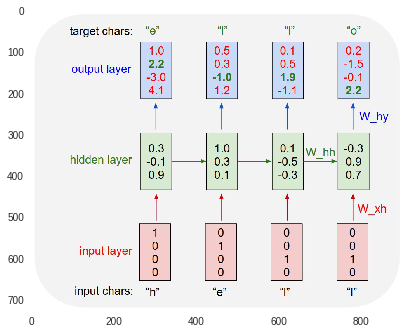

In [38]:
### Character-wise RNN network image
character_sequence = mpimg.imread("/content/drive/My Drive/Images/charseq.jpeg") 
plt.imshow(character_sequence)
plt.grid(False)

**Load in Data.**

**Then, I will load the Anna Karenina text file and convert it into integers for my network to use.** 

In [0]:
### Open text file and read in data as `text`
with open("/content/drive/My Drive/Images/anna.txt", 'r') as f:
    text = f.read()

**Let's check out the first 100 characters, to make sure everything is correct.**

In [40]:
### Check the first 100 characters
text[:100]

'Chapter 1\n\n\nHappy families are all alike; every unhappy family is unhappy in its own\nway.\n\nEverythin'

**Tokenization.**

**In the cells below, I'm creating a couple of dictionaries to convert the characters to and from integers.** 

**Encoding the characters as integers makes it easier to use as input in the network.**

In [0]:
### Encode the text and map each character to an integer and vice versa

### Create two dictionaries:
# 1. int2char, which maps integers to characters
# 2. char2int, which maps characters to unique integers
chars = tuple(set(text))
int2char = dict(enumerate(chars))
char2int = {ch: ii for ii, ch in int2char.items()}

### Encode the text
encoded = np.array([char2int[ch] for ch in text])

**And we can see those same characters from above, encoded as integers.**

In [42]:
### The encoded text
encoded[:100]

array([44, 79, 35, 61, 59,  3, 36, 26, 76, 58, 58, 58, 23, 35, 61, 61, 16,
       26, 81, 35, 39, 75, 38, 75,  3, 18, 26, 35, 36,  3, 26, 35, 38, 38,
       26, 35, 38, 75, 60,  3,  0, 26,  3, 57,  3, 36, 16, 26, 41, 21, 79,
       35, 61, 61, 16, 26, 81, 35, 39, 75, 38, 16, 26, 75, 18, 26, 41, 21,
       79, 35, 61, 61, 16, 26, 75, 21, 26, 75, 59, 18, 26, 54, 82, 21, 58,
       82, 35, 16, 24, 58, 58, 73, 57,  3, 36, 16, 59, 79, 75, 21])

**Pre-processing the data.**

**As you can see in my char-RNN image above, my LSTM expects an input that is one-hot encoded** 

**Meaning that each character is converted into an integer (via my created dictionary).** 

**And then converted into a column vector where only it's corresponding integer index will have the value of 1 and the rest of the vector will be filled with 0's.**

**Since I am one-hot encoding the data, I will make a function to do that.**

In [0]:
### Define a 'one_hot_encode' function
def one_hot_encode(arr, n_labels):
    
    ### Initialize the the encoded array
    one_hot = np.zeros((np.multiply(*arr.shape), n_labels), dtype=np.float32)
    
    ### Fill the appropriate elements with ones
    one_hot[np.arange(one_hot.shape[0]), arr.flatten()] = 1.
    
    ### Finally reshape it to get back to the original array
    one_hot = one_hot.reshape((*arr.shape, n_labels))
    
    return one_hot

In [44]:
### Check that the function works as expected
test_seq = np.array([[3, 5, 1]])
one_hot = one_hot_encode(test_seq, 8)

print(one_hot)

[[[0. 0. 0. 1. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 1. 0. 0.]
  [0. 1. 0. 0. 0. 0. 0. 0.]]]


**Making training mini-batches.**


**In this example, I'll take the encoded characters (passed in as the `arr` parameter) and split them into multiple sequences, given by `batch_size`.**

**Each of the sequences will be `seq_length` long.**

**Creating Batches.**

**1. The first thing we need to do is discard some of the text so we only have completely full mini-batches. **

Each batch contains $N \times M$ characters, where $N$ is the batch size (the number of sequences in a batch) and $M$ is the seq_length or number of time steps in a sequence. Then, to get the total number of batches, $K$, that we can make from the array `arr`, you divide the length of `arr` by the number of characters per batch. Once you know the number of batches, you can get the total number of characters to keep from `arr`, $N * M * K$.

**2. After that, we need to split `arr` into $N$ batches. ** 

You can do this using `arr.reshape(size)` where `size` is a tuple containing the dimensions sizes of the reshaped array. We know we want $N$ sequences in a batch, so let's make that the size of the first dimension. For the second dimension, you can use `-1` as a placeholder in the size, it'll fill up the array with the appropriate data for you. After this, you should have an array that is $N \times (M * K)$.

**3. Now that we have this array, we can iterate through it to get our mini-batches. **

The idea is each batch is a $N \times M$ window on the $N \times (M * K)$ array. For each subsequent batch, the window moves over by `seq_length`. We also want to create both the input and target arrays. Remember that the targets are just the inputs shifted over by one character. The way I like to do this window is use `range` to take steps of size `n_steps` from $0$ to `arr.shape[1]`, the total number of tokens in each sequence. That way, the integers you get from `range` always point to the start of a batch, and each window is `seq_length` wide.


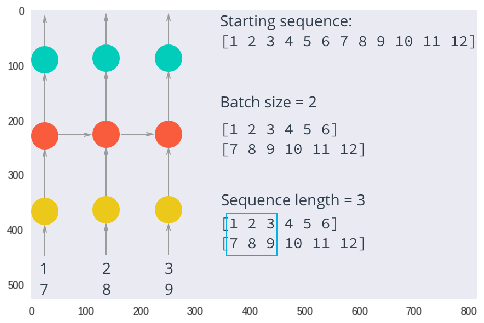

In [45]:
### To train on this data, I also want to create mini-batches for training 
### I want my batches to be multiple sequences of some desired number of sequence steps 
### Considering a simple example, the batches would look like this
sequence_batching = mpimg.imread("/content/drive/My Drive/Images/sequence_batching@1x.png") 
plt.imshow(sequence_batching)
plt.grid(False)

In [0]:
### Define 'get_batches'
def get_batches(arr, batch_size, seq_length):
    '''Create a generator that returns batches of size
       batch_size x seq_length from arr.
       
       Arguments
       ---------
       arr: Array you want to make batches from
       batch_size: Batch size, the number of sequences per batch
       seq_length: Number of encoded chars in a sequence
    '''
    
    batch_size_total = batch_size * seq_length
    ### Total number of batches we can make
    n_batches = len(arr)//batch_size_total
    
    ### Keep only enough characters to make full batches
    arr = arr[:n_batches * batch_size_total]
    
    ### Reshape into batch_size rows
    arr = arr.reshape((batch_size, -1))
    
    ### Iterate through the array, one sequence at a time
    for n in range(0, arr.shape[1], seq_length):
        # The features
        x = arr[:, n:n+seq_length]
        # The targets, shifted by one
        y = np.zeros_like(x)
        try:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, n+seq_length]
        except IndexError:
            y[:, :-1], y[:, -1] = x[:, 1:], arr[:, 0]
        yield x, y

**Test The Implementation.**

**Now I'll make some data sets so I can check out what's going on as I batch data.**

**Here, as an example, I'm going to use a batch size of 8 and 50 sequence steps.**

In [0]:
### Test the batching function
batches = get_batches(encoded, 8, 50)
x, y = next(batches)

In [48]:
### Print out the first 10 items in a sequence
print('x\n', x[:10, :10])
print('\ny\n', y[:10, :10])

x
 [[44 79 35 61 59  3 36 26 76 58]
 [18 54 21 26 59 79 35 59 26 35]
 [ 3 21 13 26 54 36 26 35 26 81]
 [18 26 59 79  3 26 70 79 75  3]
 [26 18 35 82 26 79  3 36 26 59]
 [70 41 18 18 75 54 21 26 35 21]
 [26 56 21 21 35 26 79 35 13 26]
 [50 22 38 54 21 18 60 16 24 26]]

y
 [[79 35 61 59  3 36 26 76 58 58]
 [54 21 26 59 79 35 59 26 35 59]
 [21 13 26 54 36 26 35 26 81 54]
 [26 59 79  3 26 70 79 75  3 81]
 [18 35 82 26 79  3 36 26 59  3]
 [41 18 18 75 54 21 26 35 21 13]
 [56 21 21 35 26 79 35 13 26 18]
 [22 38 54 21 18 60 16 24 26 65]]


**If I implemented `get_batches` correctly, the above output should look something like.** 
```
x
 [[25  8 60 11 45 27 28 73  1  2]
 [17  7 20 73 45  8 60 45 73 60]
 [27 20 80 73  7 28 73 60 73 65]
 [17 73 45  8 27 73 66  8 46 27]
 [73 17 60 12 73  8 27 28 73 45]
 [66 64 17 17 46  7 20 73 60 20]
 [73 76 20 20 60 73  8 60 80 73]
 [47 35 43  7 20 17 24 50 37 73]]

y
 [[ 8 60 11 45 27 28 73  1  2  2]
 [ 7 20 73 45  8 60 45 73 60 45]
 [20 80 73  7 28 73 60 73 65  7]
 [73 45  8 27 73 66  8 46 27 65]
 [17 60 12 73  8 27 28 73 45 27]
 [64 17 17 46  7 20 73 60 20 80]
 [76 20 20 60 73  8 60 80 73 17]
 [35 43  7 20 17 24 50 37 73 36]]
 ```
 **although the exact numbers may be different. Check to make sure the data is shifted over one step for `y`.**

---
**Defining the network with PyTorch.**

**Below is where I will define the network.**

**I will use PyTorch to define the architecture of the network.**

**I start by defining the layers and operations I want.**

**Then, I will define a method for the forward pass.** 

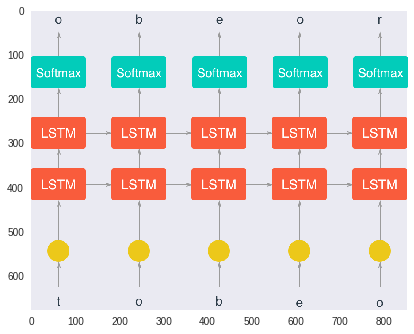

In [49]:
### Layers and activations of an RNN
char_rnn = mpimg.imread("/content/drive/My Drive/Images/charRNN.png") 
plt.imshow(char_rnn)
plt.grid(False)

**Model Structure.**

* Create and store the necessary dictionaries
* Define an LSTM layer that takes as params: an input size (the number of characters), a hidden layer size `n_hidden`, a number of layers `n_layers`, a dropout probability `drop_prob`, and a batch_first boolean (True, since we are batching)
* Define a dropout layer with `dropout_prob`
* Define a fully-connected layer with params: input size `n_hidden` and output size (the number of characters)
* Finally, initialize the weights 

---
**LSTM Inputs/Outputs.**

**I will  create a basic [LSTM layer](https://pytorch.org/docs/stable/nn.html#lstm) as follows.**

```python
self.lstm = nn.LSTM(input_size, n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
```

where `input_size` is the number of characters this cell expects to see as sequential input, and `n_hidden` is the number of units in the hidden layers in the cell. And we can add dropout by adding a dropout parameter with a specified probability; this will automatically add dropout to the inputs or outputs. Finally, in the `forward` function, we can stack up the LSTM cells into layers using `.view`. With this, you pass in a list of cells and it will send the output of one cell into the next cell.

We also need to create an initial hidden state of all zeros. This is done like so

```python
self.init_hidden()
```

In [50]:
### Check if GPU is available
train_on_gpu = torch.cuda.is_available()
if(train_on_gpu):
    print('Training on GPU!')
else: 
    print('No GPU available, training on CPU; consider making n_epochs very small.')

Training on GPU!


In [0]:
class CharRNN(nn.Module):
    
    def __init__(self, tokens, n_hidden=256, n_layers=2,
                               drop_prob=0.5, lr=0.001):
        super().__init__()
        self.drop_prob = drop_prob
        self.n_layers = n_layers
        self.n_hidden = n_hidden
        self.lr = lr
        
        ### Creating character dictionaries
        self.chars = tokens
        self.int2char = dict(enumerate(self.chars))
        self.char2int = {ch: ii for ii, ch in self.int2char.items()}
        
        ### Define the LSTM
        self.lstm = nn.LSTM(len(self.chars), n_hidden, n_layers, 
                            dropout=drop_prob, batch_first=True)
        
        ### Define a dropout layer
        self.dropout = nn.Dropout(drop_prob)
        
        ### Define the final, fully-connected output layer
        self.fc = nn.Linear(n_hidden, len(self.chars))
      
    
    def forward(self, x, hidden):
        ''' Forward pass through the network. 
            These inputs are x, and the hidden/cell state `hidden`. '''
                
        ### Get the outputs and the new hidden state from the lstm
        r_output, hidden = self.lstm(x, hidden)
        
        ### Pass through a dropout layer
        out = self.dropout(r_output)
        
        ### Stack up LSTM outputs using view
        ### I may need to use contiguous to reshape the output
        out = out.contiguous().view(-1, self.n_hidden)
        
        ### Put x through the fully-connected layer
        out = self.fc(out)
        
        ### Return the final output and the hidden state
        return out, hidden
    
    
    def init_hidden(self, batch_size):
        ''' Initializes hidden state '''
        ### Create two new tensors with sizes n_layers x batch_size x n_hidden,
        ### Initialized to zero, for hidden state and cell state of LSTM
        weight = next(self.parameters()).data
        
        if (train_on_gpu):
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda(),
                  weight.new(self.n_layers, batch_size, self.n_hidden).zero_().cuda())
        else:
            hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_(),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_())
        
        return hidden

## Time to train

The train function gives me the ability to set the number of epochs, the learning rate, and other parameters.

Below I am using an Adam optimizer and cross entropy loss since I am looking at character class scores as output. I calculate the loss and perform backpropagation, as usual.

A couple of details about training: 
>* Within the batch loop, I detach the hidden state from its history; this time setting it equal to a new *tuple* variable because an LSTM has a hidden state that is a tuple of the hidden and cell states.
* I use [`clip_grad_norm_`](https://pytorch.org/docs/stable/_modules/torch/nn/utils/clip_grad.html) to help prevent exploding gradients.

In [0]:
def train(net, data, epochs=10, batch_size=10, seq_length=50, lr=0.001, clip=5, val_frac=0.1, print_every=10):
    ''' Training a network 
    
        Arguments
        ---------
        
        net: CharRNN network
        data: text data to train the network
        epochs: Number of epochs to train
        batch_size: Number of mini-sequences per mini-batch, aka batch size
        seq_length: Number of character steps per mini-batch
        lr: learning rate
        clip: gradient clipping
        val_frac: Fraction of data to hold out for validation
        print_every: Number of steps for printing training and validation loss
    
    '''
    net.train()
    
    opt = torch.optim.Adam(net.parameters(), lr=lr)
    criterion = nn.CrossEntropyLoss()
    
    ### Create training and validation data
    val_idx = int(len(data)*(1-val_frac))
    data, val_data = data[:val_idx], data[val_idx:]
    
    if(train_on_gpu):
        net.cuda()
    
    counter = 0
    n_chars = len(net.chars)
    for e in range(epochs):
        ### Initialize hidden state
        h = net.init_hidden(batch_size)
        
        for x, y in get_batches(data, batch_size, seq_length):
            counter += 1
            
            ### One-hot encode the data and make them Torch tensors
            x = one_hot_encode(x, n_chars)
            inputs, targets = torch.from_numpy(x), torch.from_numpy(y)
            
            if(train_on_gpu):
                inputs, targets = inputs.cuda(), targets.cuda()

            ### Creating new variables for the hidden state, otherwise
            ### the code would backprop through the entire training history
            h = tuple([each.data for each in h])

            ### Zero accumulated gradients
            net.zero_grad()
            
            ### Get the output from the model
            output, h = net(inputs, h)
            
            ### Calculate the loss and perform backprop
            loss = criterion(output, targets.view(batch_size*seq_length))
            loss.backward()
            
            ### `clip_grad_norm` helps prevent the exploding gradient problem in RNNs / LSTMs.
            nn.utils.clip_grad_norm_(net.parameters(), clip)
            opt.step()
            
            ### Loss stats
            if counter % print_every == 0:
                ### Get validation loss
                val_h = net.init_hidden(batch_size)
                val_losses = []
                net.eval()
                for x, y in get_batches(val_data, batch_size, seq_length):
                    
                    ### One-hot encode our data and make them Torch tensors
                    x = one_hot_encode(x, n_chars)
                    x, y = torch.from_numpy(x), torch.from_numpy(y)
                    
                    ### Creating new variables for the hidden state, otherwise
                    ### the code would backprop through the entire training history
                    val_h = tuple([each.data for each in val_h])
                    
                    inputs, targets = x, y
                    if(train_on_gpu):
                        inputs, targets = inputs.cuda(), targets.cuda()

                    output, val_h = net(inputs, val_h)
                    val_loss = criterion(output, targets.view(batch_size*seq_length))
                
                    val_losses.append(val_loss.item())
                
                net.train() # reset to train mode after iterating through validation data
                
                print("Epoch: {}/{}...".format(e+1, epochs),
                      "Step: {}...".format(counter),
                      "Loss: {:.4f}...".format(loss.item()),
                      "Val Loss: {:.4f}".format(np.mean(val_losses)))

**Instantiating the model.**

**Now I can actually train the network.** 

**First I'll create the network itself, with some given hyperparameters.**

**Then, define the mini-batches sizes, and start training.** 

In [53]:
### Define and print the net
n_hidden=512
n_layers=2

net = CharRNN(chars, n_hidden, n_layers)
print(net)

CharRNN(
  (lstm): LSTM(83, 512, num_layers=2, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5)
  (fc): Linear(in_features=512, out_features=83, bias=True)
)


In [54]:
### Define mini_batches
batch_size = 128
seq_length = 100
n_epochs = 1 

### Train the model
train(net, encoded, epochs=n_epochs, batch_size=batch_size, seq_length=seq_length, lr=0.001, print_every=10)

Epoch: 1/1... Step: 10... Loss: 3.2603... Val Loss: 3.2075
Epoch: 1/1... Step: 20... Loss: 3.1482... Val Loss: 3.1394
Epoch: 1/1... Step: 30... Loss: 3.1430... Val Loss: 3.1238
Epoch: 1/1... Step: 40... Loss: 3.1145... Val Loss: 3.1191
Epoch: 1/1... Step: 50... Loss: 3.1409... Val Loss: 3.1172
Epoch: 1/1... Step: 60... Loss: 3.1181... Val Loss: 3.1150
Epoch: 1/1... Step: 70... Loss: 3.1090... Val Loss: 3.1130
Epoch: 1/1... Step: 80... Loss: 3.1180... Val Loss: 3.1062
Epoch: 1/1... Step: 90... Loss: 3.1096... Val Loss: 3.0909
Epoch: 1/1... Step: 100... Loss: 3.0697... Val Loss: 3.0561
Epoch: 1/1... Step: 110... Loss: 3.0181... Val Loss: 2.9963
Epoch: 1/1... Step: 120... Loss: 2.8986... Val Loss: 2.8820
Epoch: 1/1... Step: 130... Loss: 2.8250... Val Loss: 2.7899


**Getting the best model.**

**To set the hyperparameters to get the best performance, I'll want to watch the training and validation losses.**

**If the training loss is much lower than the validation loss, the model is overfitting.** 

**Increase regularization (more dropout) or use a smaller network.** 

**If the training and validation losses are close, the model is underfitting so I can increase the size of the network.**

## Hyperparameters

Here are the hyperparameters for the network.

In defining the model:
* `n_hidden` - The number of units in the hidden layers.
* `n_layers` - Number of hidden LSTM layers to use.

We assume that dropout probability and learning rate will be kept at the default, in this example.

And in training:
* `batch_size` - Number of sequences running through the network in one pass.
* `seq_length` - Number of characters in the sequence the network is trained on. Larger is better typically, the network will learn more long range dependencies. But it takes longer to train. 100 is typically a good number here.
* `lr` - Learning rate for training

> ## Tips and Tricks

>### Monitoring Validation Loss vs. Training Loss
>If you're somewhat new to Machine Learning or Neural Networks it can take a bit of expertise to get good models. The most important quantity to keep track of is the difference between your training loss (printed during training) and the validation loss (printed once in a while when the RNN is run on the validation data (by default every 1000 iterations)). In particular:

> - If your training loss is much lower than validation loss then this means the network might be **overfitting**. Solutions to this are to decrease your network size, or to increase dropout. For example you could try dropout of 0.5 and so on.
> - If your training/validation loss are about equal then your model is **underfitting**. Increase the size of your model (either number of layers or the raw number of neurons per layer)

> ### Approximate number of parameters

> The two most important parameters that control the model are `n_hidden` and `n_layers`. I would advise that you always use `n_layers` of either 2/3. The `n_hidden` can be adjusted based on how much data you have. The two important quantities to keep track of here are:

> - The number of parameters in your model. This is printed when you start training.
> - The size of your dataset. 1MB file is approximately 1 million characters.

>These two should be about the same order of magnitude. It's a little tricky to tell. Here are some examples:

> - I have a 100MB dataset and I'm using the default parameter settings (which currently print 150K parameters). My data size is significantly larger (100 mil >> 0.15 mil), so I expect to heavily underfit. I am thinking I can comfortably afford to make `n_hidden` larger.
> - I have a 10MB dataset and running a 10 million parameter model. I'm slightly nervous and I'm carefully monitoring my validation loss. If it's larger than my training loss then I may want to try to increase dropout a bit and see if that helps the validation loss.

> ### Best models strategy

>The winning strategy to obtaining very good models (if you have the compute time) is to always err on making the network larger (as large as you're willing to wait for it to compute) and then try different dropout values (between 0,1). Whatever model has the best validation performance (the loss, written in the checkpoint filename, low is good) is the one you should use in the end.

>It is very common in deep learning to run many different models with many different hyperparameter settings, and in the end take whatever checkpoint gave the best validation performance.

>By the way, the size of your training and validation splits are also parameters. Make sure you have a decent amount of data in your validation set or otherwise the validation performance will be noisy and not very informative.

## Checkpoint

**After training, I'll save the model so I can load it again later if I need too.** 

**Here I'm saving the parameters needed to create the same architecture, the hidden layer hyperparameters and the text characters.**

In [0]:
### Change the name, for saving multiple files
model_name = 'rnn_20_epoch.net'

checkpoint = {'n_hidden': net.n_hidden,
              'n_layers': net.n_layers,
              'state_dict': net.state_dict(),
              'tokens': net.chars}

with open(model_name, 'wb') as f:
    torch.save(checkpoint, f)

---
## Making Predictions

Now that the model is trained, we'll want to sample from it and make predictions about next characters! To sample, we pass in a character and have the network predict the next character. Then we take that character, pass it back in, and get another predicted character. Just keep doing this and you'll generate a bunch of text!

### A note on the `predict`  function

The output of our RNN is from a fully-connected layer and it outputs a **distribution of next-character scores**.

> To actually get the next character, we apply a softmax function, which gives us a *probability* distribution that we can then sample to predict the next character.

### Top K sampling

Our predictions come from a categorical probability distribution over all the possible characters. We can make the sample text and make it more reasonable to handle (with less variables) by only considering some $K$ most probable characters. This will prevent the network from giving us completely absurd characters while allowing it to introduce some noise and randomness into the sampled text. Read more about [topk, here](https://pytorch.org/docs/stable/torch.html#torch.topk).


In [0]:
def predict(net, char, h=None, top_k=None):
        ''' Given a character, predict the next character.
            Returns the predicted character and the hidden state.
        '''
        
        # tensor inputs
        x = np.array([[net.char2int[char]]])
        x = one_hot_encode(x, len(net.chars))
        inputs = torch.from_numpy(x)
        
        if(train_on_gpu):
            inputs = inputs.cuda()
        
        # detach hidden state from history
        h = tuple([each.data for each in h])
        # get the output of the model
        out, h = net(inputs, h)

        # get the character probabilities
        p = F.softmax(out, dim=1).data
        if(train_on_gpu):
            p = p.cpu() # move to cpu
        
        # get top characters
        if top_k is None:
            top_ch = np.arange(len(net.chars))
        else:
            p, top_ch = p.topk(top_k)
            top_ch = top_ch.numpy().squeeze()
        
        # select the likely next character with some element of randomness
        p = p.numpy().squeeze()
        char = np.random.choice(top_ch, p=p/p.sum())
        
        # return the encoded value of the predicted char and the hidden state
        return net.int2char[char], h

### Priming and generating text 

Typically you'll want to prime the network so you can build up a hidden state. Otherwise the network will start out generating characters at random. In general the first bunch of characters will be a little rough since it hasn't built up a long history of characters to predict from.

In [0]:
def sample(net, size, prime='The', top_k=None):
        
    if(train_on_gpu):
        net.cuda()
    else:
        net.cpu()
    
    net.eval() # eval mode
    
    # First off, run through the prime characters
    chars = [ch for ch in prime]
    h = net.init_hidden(1)
    for ch in prime:
        char, h = predict(net, ch, h, top_k=top_k)

    chars.append(char)
    
    # Now pass in the previous character and get a new one
    for ii in range(size):
        char, h = predict(net, chars[-1], h, top_k=top_k)
        chars.append(char)

    return ''.join(chars)

In [58]:
print(sample(net, 1000, prime='Anna', top_k=5))

Annan  aed tare he e ee tired
 he tirt had har tie asta a aad ant hare aed an tar aon aa sied ia  atthes tees ho  ho thes ittat oan  aet oed an etestes ot etitt har hhe etang ae het to  hhi thon  he  hit tirethod at eed annt arind ton tond tart ae hher io  ao  oir the had hh shon he thard hanten torttis tond oat teredd an ha thir thhe  hhi ta attar iod thodss hin torteses oe thes an atirens
 horens onn ho  hi te artits her eadset oedd tin at and horss ata ethat tote tint inns hh ass atan as the  ied at hat hhe sit te ee tan thetsin ha soest hen ha te entestit an  har thare ha  aon ann  anredtas aa a aet on ae  he the tartta hantthhe  oong atatin hhi sens atis on iostir ee aes ae ans ie end en tar ther hotit oa hhe then ied an ian  hhe ton thins he hate at ont an ha tee ata  in eters hhrrist on tae hiti hor on the  ha  earet on and itte tho te ae tares oan ae  at he aadst are tha hirtare oe hartan aos on e etat hot onn  oond, ie  aot on atit hid tan etins ior enti ae ae ther ans annte t

## Loading a checkpoint

In [0]:
### Here we have loaded in a model that trained over 20 epochs `rnn_20_epoch.net`
with open('rnn_20_epoch.net', 'rb') as f:
    checkpoint = torch.load(f)
    
loaded = CharRNN(checkpoint['tokens'], n_hidden=checkpoint['n_hidden'], n_layers=checkpoint['n_layers'])
loaded.load_state_dict(checkpoint['state_dict'])

In [60]:
### Sample using a loaded model
print(sample(loaded, 2000, top_k=5, prime="And Levin said"))

And Levin said  eose hod io an hh tetthad hens aad hhr hed tons ae een had hhedse oente eesend ta thod tho shatiss tar ea and it end tis atthe tees hhed ian tand, on to ennd ann tee aod eteretthe aa  hat onte hh sate thhrri no et arint at ete iong aesed hhe an thet ta  hot an tot tae the tin thi tonn  ao  east aen at hentetes
sotes inndd her at oo  iars ins tors aa  oa ten ten hhed an aa  oeneg ta a ta enn te ast hed tar he te aret iod hi  eeritestin atsirn ont ar hots ao  hond oer oos ae e hor ethed tho thon  herti hirtin tho  han tor etenn at ant hh es tan tha toe hod aot eend an tan anse on iti tan he hod aans hat ho  eas oer annte at hhrrendd hin aa sathon atarin hant oot the ate ees an hond ao toet he atit herenn heret aod thar hed ote tat ant hort oen attin ha esit ei  ar eis ao tand atethen
nat he aod iots oed thi etan  ae an in he tho  ae an ho  hit ot tie hat hand thin terind he hhe anttan toes hh  aor his thin the  en aidd aod hett an hed thed tonn ao hh  on toe hor hir ho th